In [53]:
from nltk.corpus import brown
from nltk import FreqDist
from gensim.models import KeyedVectors
from scipy.stats import pearsonr
import numpy as np
from scipy.spatial.distance import cosine

Load data

In [54]:
import pickle
with open("embeddings/data.pkl", "rb") as file:
    data = pickle.load(file)

words = data['w']
dataset = data['d']
embeddings = data['E']


In [55]:
# cosine distance between the first and last decade
def method_1(embeddings):
    return cosine(embeddings[0], embeddings[-1])

In [56]:
# maximum cosine distance between each consecutive decade
def method_2(embeddings):
    return max([cosine(embeddings[i], embeddings[i+1]) for i in range(len(embeddings)-1)])

In [57]:
# average cosine distance per decade change
def method_3(embeddings):
    return np.mean([cosine(embeddings[i], embeddings[i+1]) for i in range(len(embeddings)-1)])

In [58]:
changes_method_1 = [method_1(embeddings[i]) for i in range(len(words))]
changes_method_2 = [method_2(embeddings[i]) for i in range(len(words))]
changes_method_3 = [method_3(embeddings[i]) for i in range(len(words))]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


### Top 20 words for each method

In [59]:
words_changes = list(zip(words, changes_method_1, changes_method_2, changes_method_3))

for index, method in enumerate(["method1_change", "method2_change", "method3_change"]):
    sorted_by_change = sorted(words_changes, key=lambda x: x[index+1], reverse=True)  # Sorting by the change for the specific method

    top_20_most = sorted_by_change[:20]
    top_20_least = sorted_by_change[-20:]

    print(f"Top 20 most changing words for {method}:")
    for item in top_20_most:
        print(item[0], item[index+1])  # Only printing lemma and its corresponding score
    print("\n")
    
    print(f"Top 20 least changing words for {method}:")
    for item in top_20_least:
        print(item[0], item[index+1])  # Only printing lemma and its corresponding score
    print("\n")

Top 20 most changing words for method1_change:
programs 0.9908060408371938
objectives 0.9777930257849913
computer 0.9612410643483436
radio 0.9052701147159458
sector 0.9006836366602485
goals 0.8451478071876328
approach 0.8398605922816097
van 0.8367483908002056
shri 0.8244319851175984
media 0.8125349168703303
impact 0.8000341939038889
perspective 0.7931199949661135
patterns 0.7823269040416171
berkeley 0.7779084933889083
shift 0.776931638140915
film 0.7759189348198611
assessment 0.7681167960046129
stanford 0.7674790427852327
challenge 0.766492057078026
therapy 0.7608242054204954


Top 20 least changing words for method1_change:
week 0.31992764436258936
feet 0.3186646029282473
september 0.31786901281959457
god 0.3150845082973782
december 0.31373757998712104
daughter 0.3116770598907621
months 0.30972055852261215
century 0.30730617145950145
january 0.30179555011777637
increase 0.30143007605515715
october 0.2971440393982766
years 0.2907269356601365
february 0.28636454155874524
november 0.2825

### Measure the intercorrelations (of semantic change in all words, given the embeddings from Step 1) among the three methods you have proposed and summarize the Pearson correlations in a 3-by-3 table

In [60]:


cor_12, _ = pearsonr(changes_method_1, changes_method_2)
cor_13, _ = pearsonr(changes_method_1, changes_method_3)
cor_23, _ = pearsonr(changes_method_2, changes_method_3)

correlation_matrix = np.array([[1, cor_12, cor_13],
                               [cor_12, 1, cor_23],
                               [cor_13, cor_23, 1]])

print(correlation_matrix)

[[1.         0.61023698 0.64038365]
 [0.61023698 1.         0.81572133]
 [0.64038365 0.81572133 1.        ]]


### Accuracy Test

In [61]:
def get_embeddings(lemma): # only adding lemmas in words
    if lemma in words:
        index = words.index(lemma)
        return embeddings[index]
    else:
        return None

In [62]:
import pandas as pd
df = pd.read_csv('aggregate.csv')
df['sim_score_list'] = df['sim_score'].str.split()
df['sim_score_list'] = df['sim_score_list'].apply(lambda x: [int(score) for score in x])
df['sim_score_mean'] = df['sim_score_list'].apply(np.mean) # taking average score
# only looking at highest scores
df = df.sort_values(by='sim_score_mean', ascending=False).drop_duplicates(subset='lemma', keep='first')
df['sim_score_mean'] = df['sim_score_mean'] / 4 # making scores more comparable
valid_lemmas = df['lemma'].apply(lambda lemma: lemma in words)

# Compute semantic changes for valid lemmas using each method
df.loc[valid_lemmas, 'method_1_change'] = df[valid_lemmas]['lemma'].apply(lambda lemma: method_1(get_embeddings(lemma)))
df.loc[valid_lemmas, 'method_2_change'] = df[valid_lemmas]['lemma'].apply(lambda lemma: method_2(get_embeddings(lemma)))
df.loc[valid_lemmas, 'method_3_change'] = df[valid_lemmas]['lemma'].apply(lambda lemma: method_3(get_embeddings(lemma)))

3285


In [63]:
# calculate correlations between each method's results and human judgments
df = df.dropna(subset = ['method_1_change', 'method_2_change', 'method_3_change'])
correlation_method_1, _ = pearsonr(df['sim_score_mean'], df['method_1_change'])
correlation_method_2, _ = pearsonr(df['sim_score_mean'], df['method_2_change'])
correlation_method_3, _ = pearsonr(df['sim_score_mean'], df['method_3_change'])

print(f"Pearson correlation for Method 1: {correlation_method_1}")
print(f"Pearson correlation for Method 2: {correlation_method_2}")
print(f"Pearson correlation for Method 3: {correlation_method_3}")

Pearson correlation for Method 1: 0.960132915191522
Pearson correlation for Method 2: 0.878203900604992
Pearson correlation for Method 3: 0.7860157388397276


### Get top 3 words with method 1

In [64]:
sorted_df = df.sort_values(by='method_1_change', ascending=False)
unique_df = sorted_df.drop_duplicates(subset='lemma', keep='first')
top_3_lemmas = unique_df['lemma'].head(3).tolist()
top_3_lemmas

['signal', 'card', 'mirror']

### Detecting Change in Point

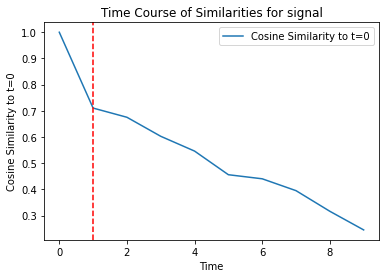

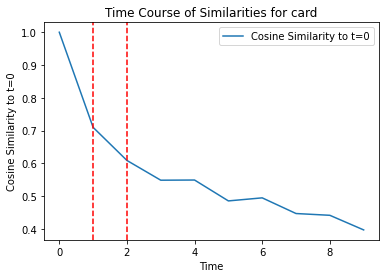

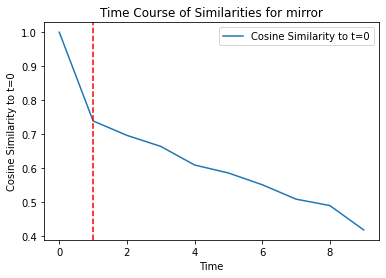

In [65]:
import matplotlib.pyplot as plt

decades = list(range(1900, 2010, 10))

def detect_change_points(similarities, threshold=0.1):
    change_points = [i for i in range(1, len(similarities)) if abs(similarities[i] - similarities[i-1]) > threshold] 
    return change_points


for word in top_3_lemmas:
    word_embeddings = get_embeddings(word)
    similarities = [1 - cosine([word_embeddings[0]], [word_embeddings[i]]) for i in range(len(word_embeddings))]
    change_points = detect_change_points(similarities)
    plt.figure()
    plt.plot(range(len(similarities)), similarities, label='Cosine Similarity to t=0')
    for cp in change_points:
        plt.axvline(x=cp, color='r', linestyle='--')
    plt.title(f'Time Course of Similarities for {word}')
    plt.xlabel('Time')
    plt.ylabel('Cosine Similarity to t=0')
    plt.legend()
    plt.show()
